## L2 norm estimation of the equivalent layer parameters

This notebook evaluates the predicted data obtained by an equivalent layer located at a specific depth.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from coord import GGS
from equiv_layer import EqLayer
from carto_map_plot import point_map
import config_style_plot as style

# Redefining functions
geodetic2cartesian = GGS().geodetic2cartesian
rotation_matrix = GGS().rotation_matrix
# Plot style
style.plot_params()

In [2]:
def L1_estim(rcl, pcl, Acc_l, it_max):
    for i in range(it_max):
#         print i
        res = rcl - np.dot(Acc_l, pcl)
        W = np.dot(Acc_l.T, np.diag(1./(np.abs(res)+1e-10)) )
        pcl = np.linalg.solve(np.dot(W, Acc_l), np.dot(W, rcl))
    return pcl

In [3]:
# IMPORTING BDG FILE
header=['LONG', 'LAT', 'ALT_GEOM', 'GRAV']
path = '../data/BDG/'
uf = 'AL'
name_bdg = '_file.txt'
bdg = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_bdg), sep='\s+',names=header, skiprows=1)
# bdg

In [4]:
# IMPORTING EIGEN FILE
name_eigen = '.dat'
eigen = pd.read_csv('{p}{u}{ne}'.format(p=path,u=uf,ne=name_eigen), sep='\s+',skiprows=32, \
                    usecols=(4,), names=['GRAV'])
# eigen

In [5]:
# Obtaining short wavelength signals
disturb = bdg.GRAV.values - eigen.GRAV.values

data = {'LONG':bdg.LONG.values, \
        'LAT':bdg.LAT.values, \
        'ALT':bdg.ALT_GEOM.values, \
        'BDG':bdg.GRAV.values, \
        'EIGEN':eigen.GRAV.values, \
        'DIST':disturb}
df = pd.DataFrame(data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST
0,-37.11800,-9.795500,195.850,978111.34,978110.164644,1.175356
1,-37.04220,-9.375600,241.660,978080.82,978083.225306,-2.405306
2,-37.12590,-9.455700,245.140,978079.77,978075.765125,4.004875
3,-37.12200,-9.542000,143.110,978108.13,978109.416045,-1.286045
4,-37.12480,-9.623800,153.160,978117.92,978112.960872,4.959128
...,...,...,...,...,...,...
203,-35.45369,-9.279924,-4.080,978138.58,978142.106459,-3.526459
204,-35.77932,-9.556829,78.985,978122.52,978128.134482,-5.614482
205,-35.71880,-9.676141,-5.777,978150.86,978150.650489,0.209511
206,-35.17401,-8.942877,-1.124,978189.45,978181.674251,7.775749


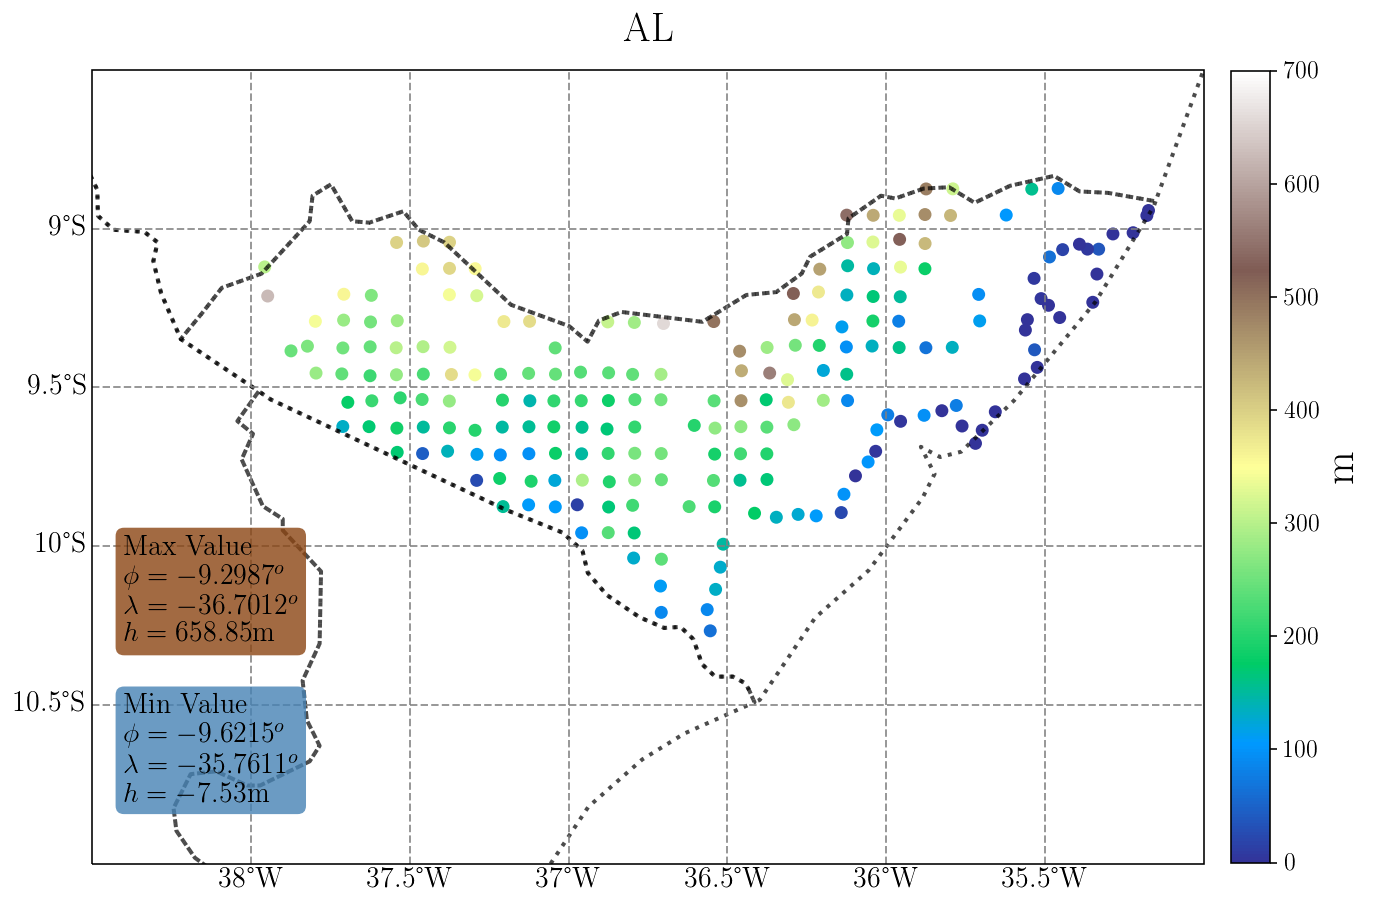

In [6]:
point_map(df.LONG, df.LAT, df.ALT, df.ALT, uf, fig_size=(12.,14.), region=[-38.5,-35,-11,-8.5], \
         sign=(-38.4,-38.4,-10.3,-10.8), cmap='terrain', shrink=0.52, lim_val=(True,True,0.,700.))

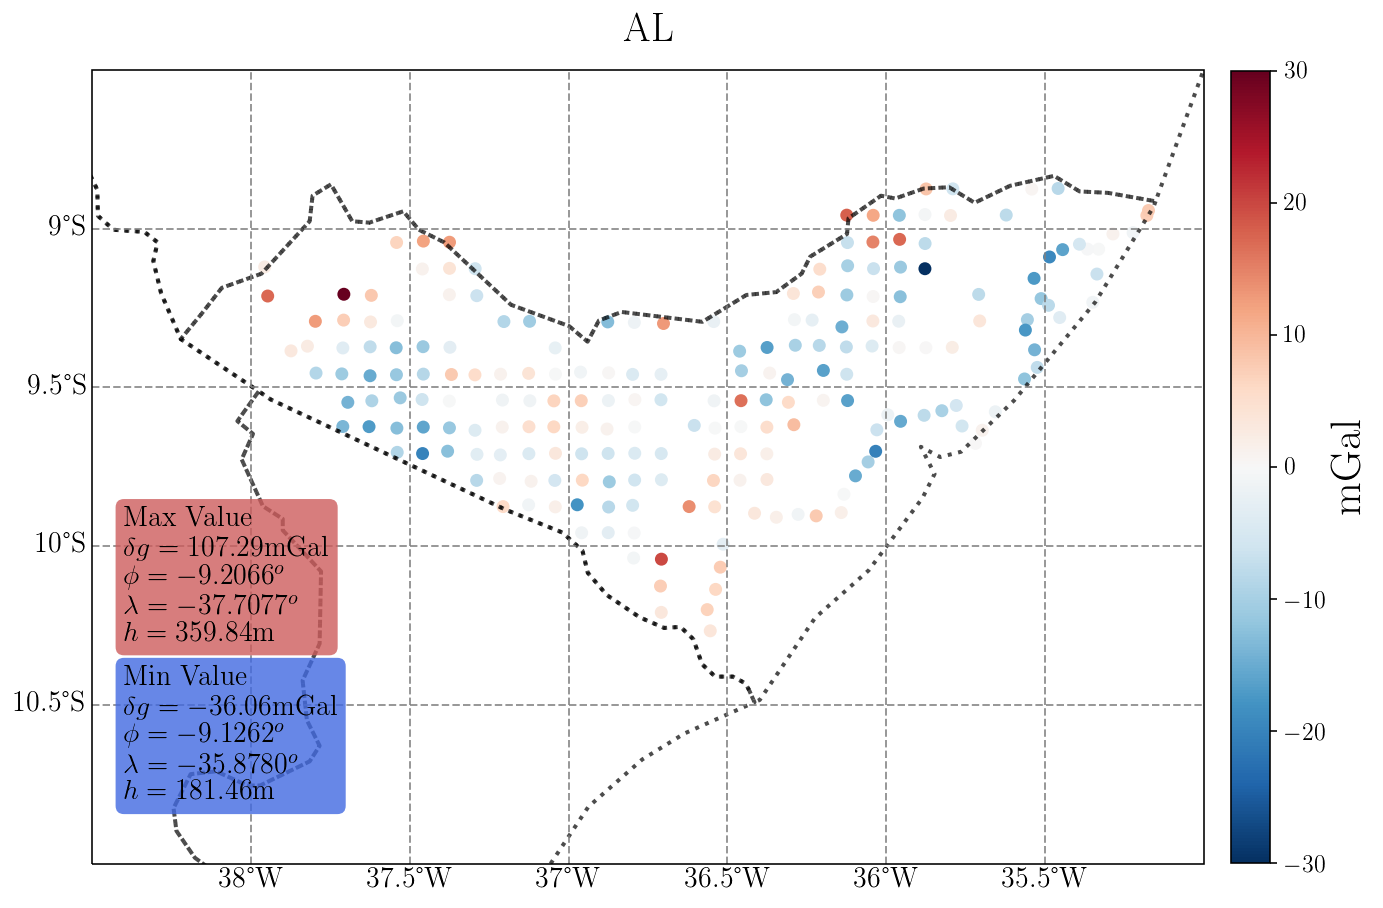

In [7]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-38.5,-35,-11,-8.5], \
         sign=(-38.4,-38.4,-10.3,-10.8), shrink=0.52, lim_val=(True, 30.))

### Calculating rotation matrices and Cartesian coordinates

In [8]:
# Calculating Cartesian coordinates
x, y, z = geodetic2cartesian(df.LONG, df.LAT, df.ALT)
R = np.array(rotation_matrix(df.LONG, df.LAT))

## Estimating the first set of point-mass parameters

In [9]:
pc = []
hc = []
indc = []
xc = []
yc = []
zc = []
Rc = []
rabs_max = []
taur = 1e-11 #1e-5 #0.05
tauc = 1e-3
it_max_l1 = 5
latc = []
lonc = []

## Iteração 1 - L2 norm

In [10]:
indl = np.arange(disturb.size)
# mi_c = 1e-5
mi_c = 1e-30
hcl = 3000. #5000. #14200. # 20000. #800. #1000.
print(hcl, type(indl)) #indl

3000.0 <class 'numpy.ndarray'>


In [11]:
rcl = disturb[indl]
xcl = x[indl]
ycl = y[indl]
zcl = z[indl]

latcl = df.LAT[indl]
loncl = df.LONG[indl]

In [12]:
Rcl = R[:, indl]

In [13]:
# Calculo de Acc_l
hlay = np.zeros(indl.size) - hcl
xlay, ylay, zlay = geodetic2cartesian(loncl, latcl, hlay)
Lay = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
layer = Lay.build_layer(xlay, ylay, zlay)
Acc_l = Lay.designMat(xcl, ycl, zcl, Rcl, layer)
print(Acc_l.shape)

(208, 208)


In [14]:
H = np.dot(Acc_l.T, Acc_l)
# H += mi_c*np.trace(H)*np.identity(indl.size)
H += (mi_c*np.trace(H)*np.identity(indl.size))/indl.size

In [15]:
p_L2 = np.linalg.solve(H, np.dot(Acc_l.T, rcl))
print(p_L2.size)
# p_L1 = L1_estim(rcl, p_L2, Acc_l, 5)

208


In [16]:
rcl -= np.dot(Acc_l, p_L2)
# print rcl[:50]

In [17]:
rabs_max_l = np.max(np.abs(rcl))
rabs_max_l

3.197442310920451e-14

In [18]:
pc.append(p_L2)
hc.append(hcl)
indc.append(indl)
xc.append(xcl)
yc.append(ycl)
zc.append(zcl)
Rc.append(Rcl)
latc.append(latcl)
lonc.append(loncl)

In [19]:
rabs_max.append(rabs_max_l)

In [20]:
rc = rcl[:] #r1
print(np.max(np.abs(rc)))

3.197442310920451e-14


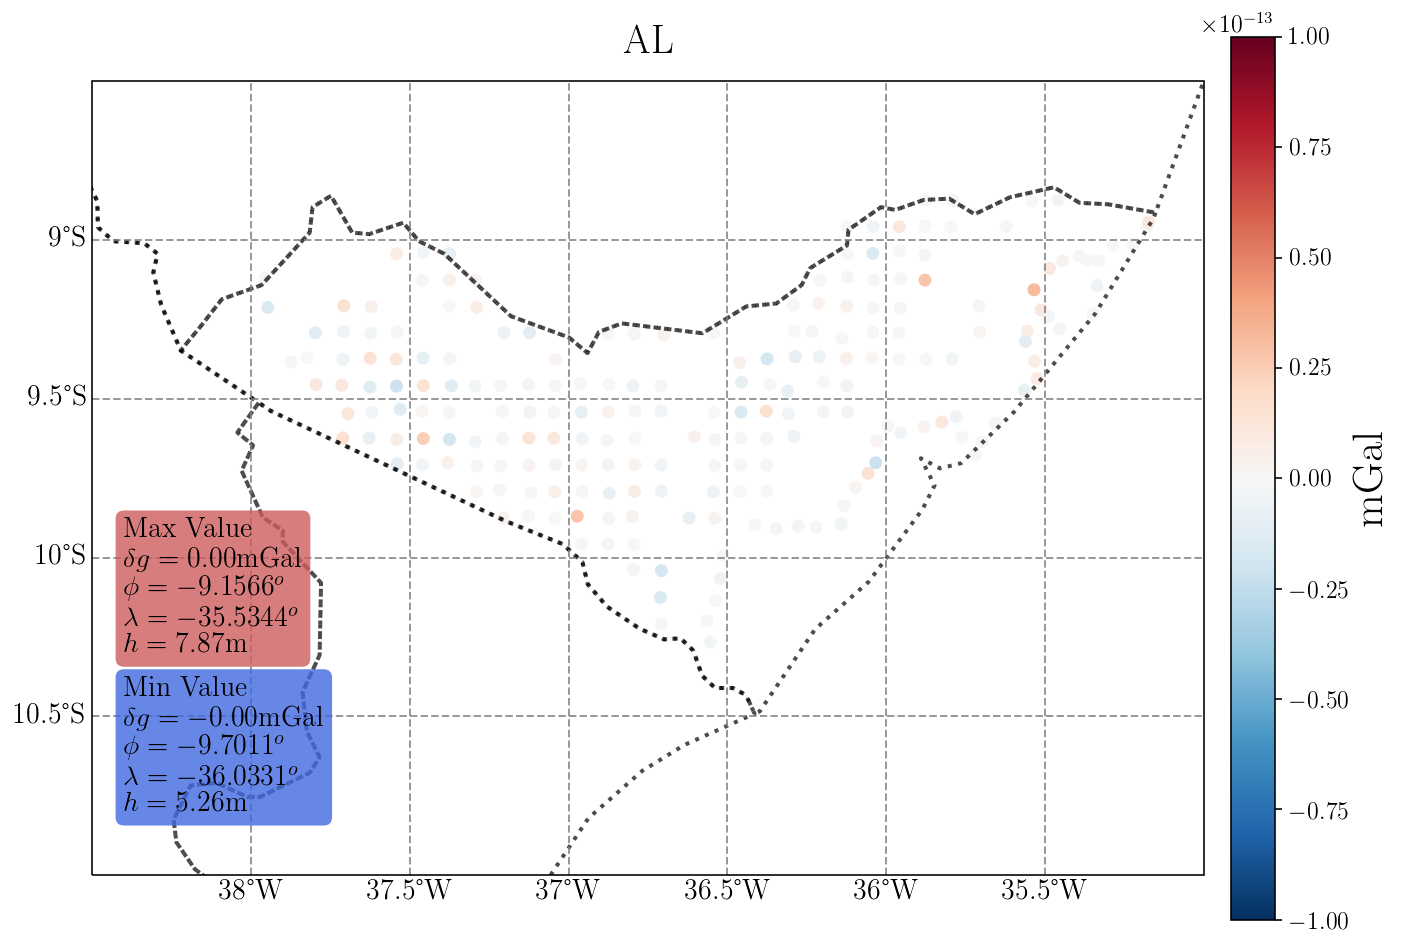

In [21]:
point_map(df.LONG, df.LAT, df.ALT, rc, uf, fig_size=(12.,14.), region=[-38.5,-35,-11,-8.5], \
         sign=(-38.4,-38.4,-10.3,-10.8), shrink=0.58, lim_val=(True, 1e-13))

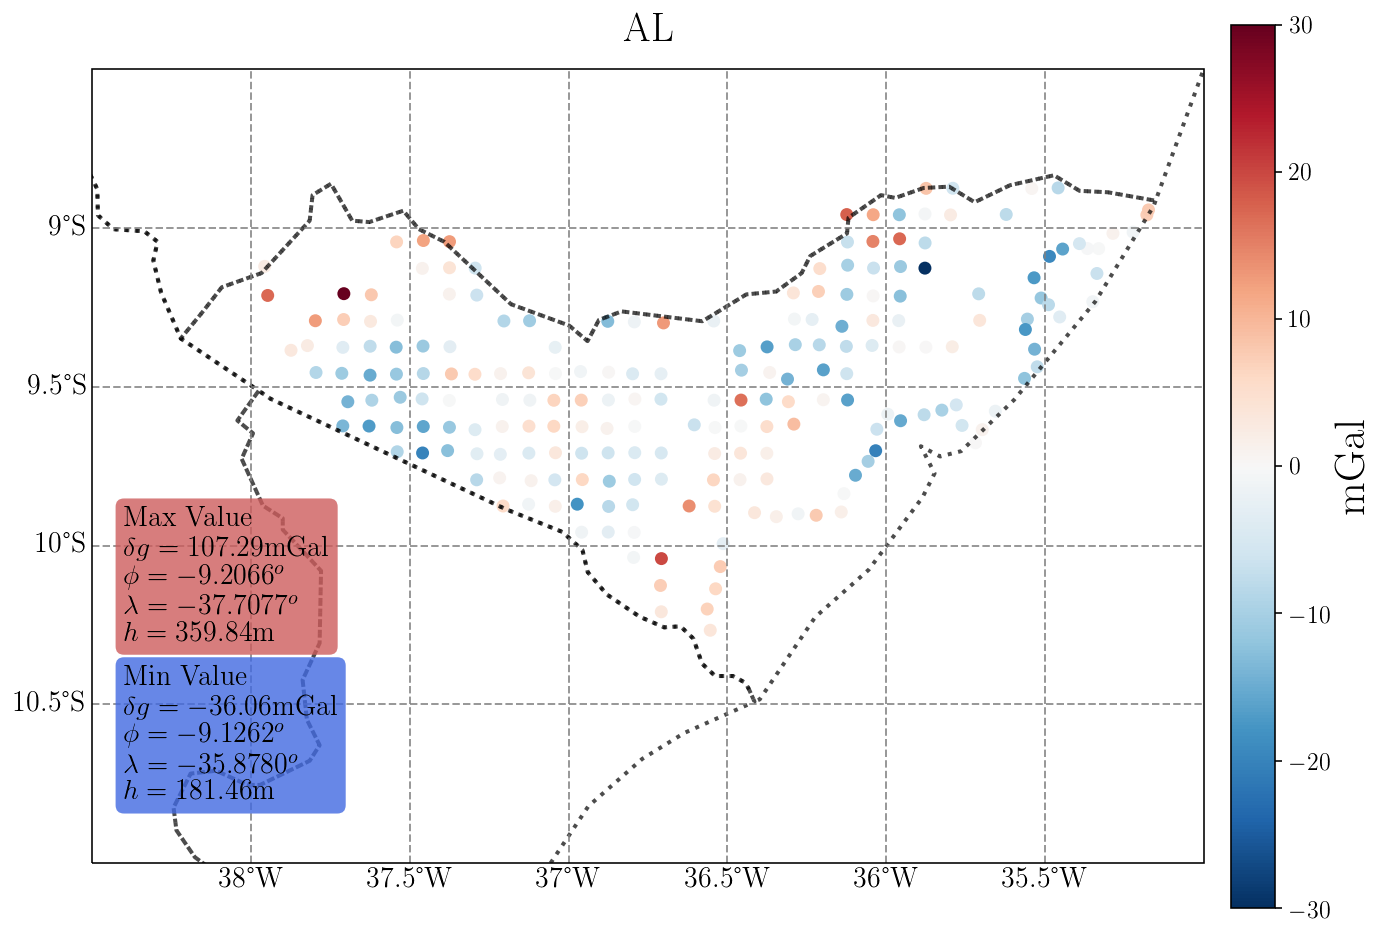

In [22]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-38.5,-35,-11,-8.5], \
         sign=(-38.4,-38.4,-10.3,-10.8), shrink=0.58, lim_val=(True, 30.))

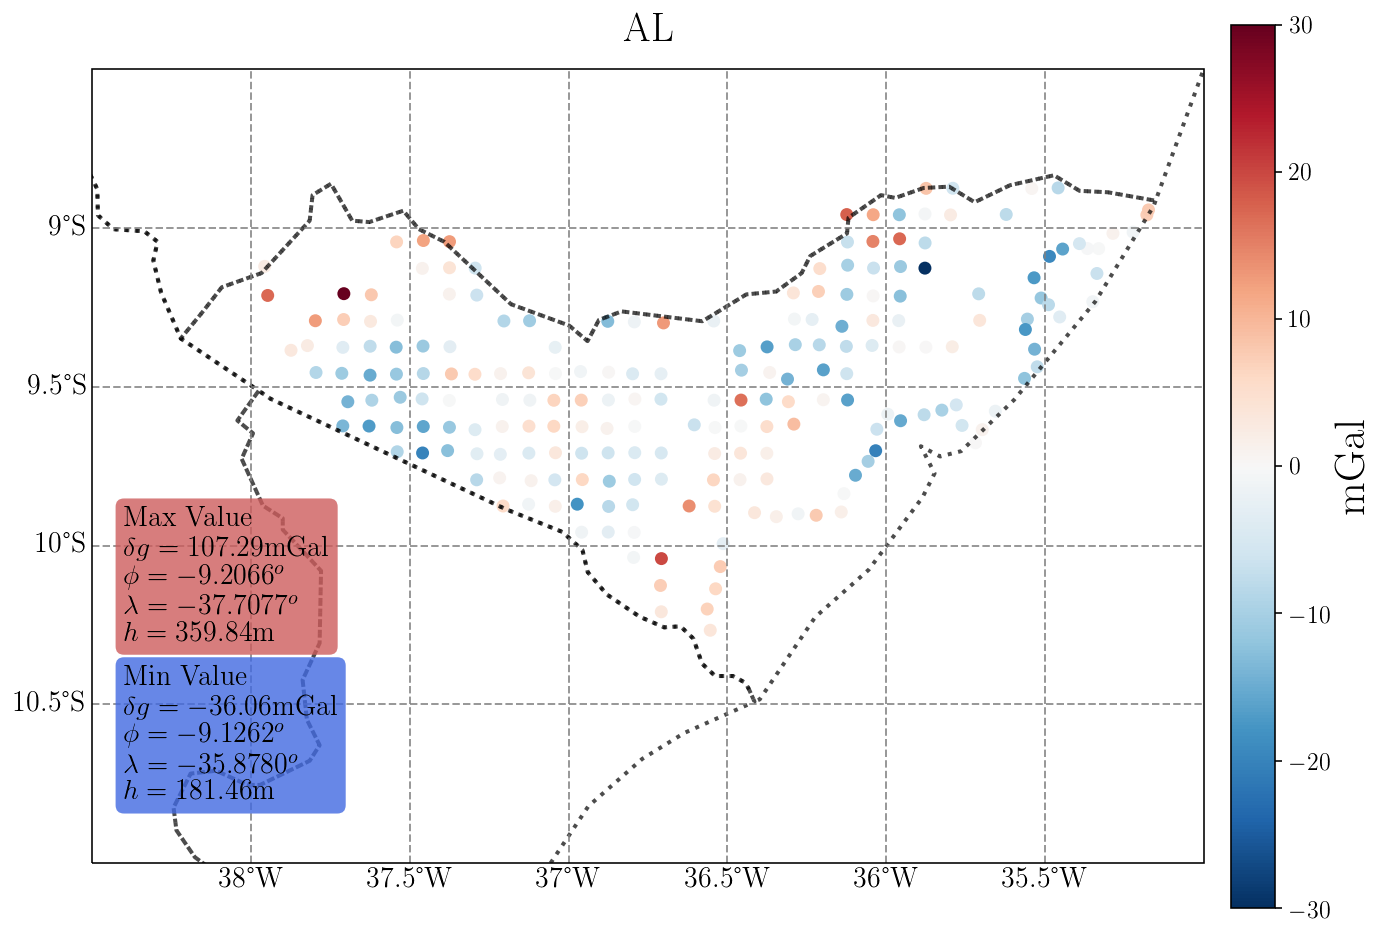

In [23]:
point_map(df.LONG, df.LAT, df.ALT, np.dot(Acc_l, p_L2), uf, fig_size=(12.,14.), region=[-38.5,-35,-11,-8.5], \
         sign=(-38.4,-38.4,-10.3,-10.8), shrink=0.58, lim_val=(True, 30.))

In [24]:
# print(len([value for value in rc if value > 1e-5]))
# print([value for value in rc if value > 1e-5])

In [25]:
new_data = {'LONG':bdg.LONG.values, \
            'LAT':bdg.LAT.values, \
            'ALT':bdg.ALT_GEOM.values, \
            'BDG':bdg.GRAV.values, \
            'EIGEN':eigen.GRAV.values, \
            'DIST':disturb, \
            'RHO':p_L2, \
            'RESID':rc}
df = pd.DataFrame(new_data)
df

,LONG,LAT,ALT,BDG,EIGEN,DIST,RHO,RESID
0,-37.11800,-9.795500,195.850,978111.34,978110.164644,1.175356,5.770282e+11,-1.332268e-15
1,-37.04220,-9.375600,241.660,978080.82,978083.225306,-2.405306,-8.307052e+11,3.108624e-15
2,-37.12590,-9.455700,245.140,978079.77,978075.765125,4.004875,1.541002e+12,-2.664535e-15
3,-37.12200,-9.542000,143.110,978108.13,978109.416045,-1.286045,-6.587511e+11,-3.552714e-15
4,-37.12480,-9.623800,153.160,978117.92,978112.960872,4.959128,1.729801e+12,1.332268e-14
...,...,...,...,...,...,...,...,...
203,-35.45369,-9.279924,-4.080,978138.58,978142.106459,-3.526459,-6.941056e+11,8.881784e-16
204,-35.77932,-9.556829,78.985,978122.52,978128.134482,-5.614482,-1.383102e+12,-4.440892e-15
205,-35.71880,-9.676141,-5.777,978150.86,978150.650489,0.209511,1.451493e+11,8.326673e-16
206,-35.17401,-8.942877,-1.124,978189.45,978181.674251,7.775749,1.652418e+12,1.065814e-14


In [26]:
print(df.RESID.min(), df.RESID.max())

-2.1316282072803006e-14 3.197442310920451e-14


### Upward Continuation

In [27]:
# up_cont = Lay.continuation(df.LONG,df.LAT,6000.,df.LONG,df.LAT,-3000.,p_L2)

In [28]:
Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,3000.,-3000.,p_L2)

The transformation is an upward continuation


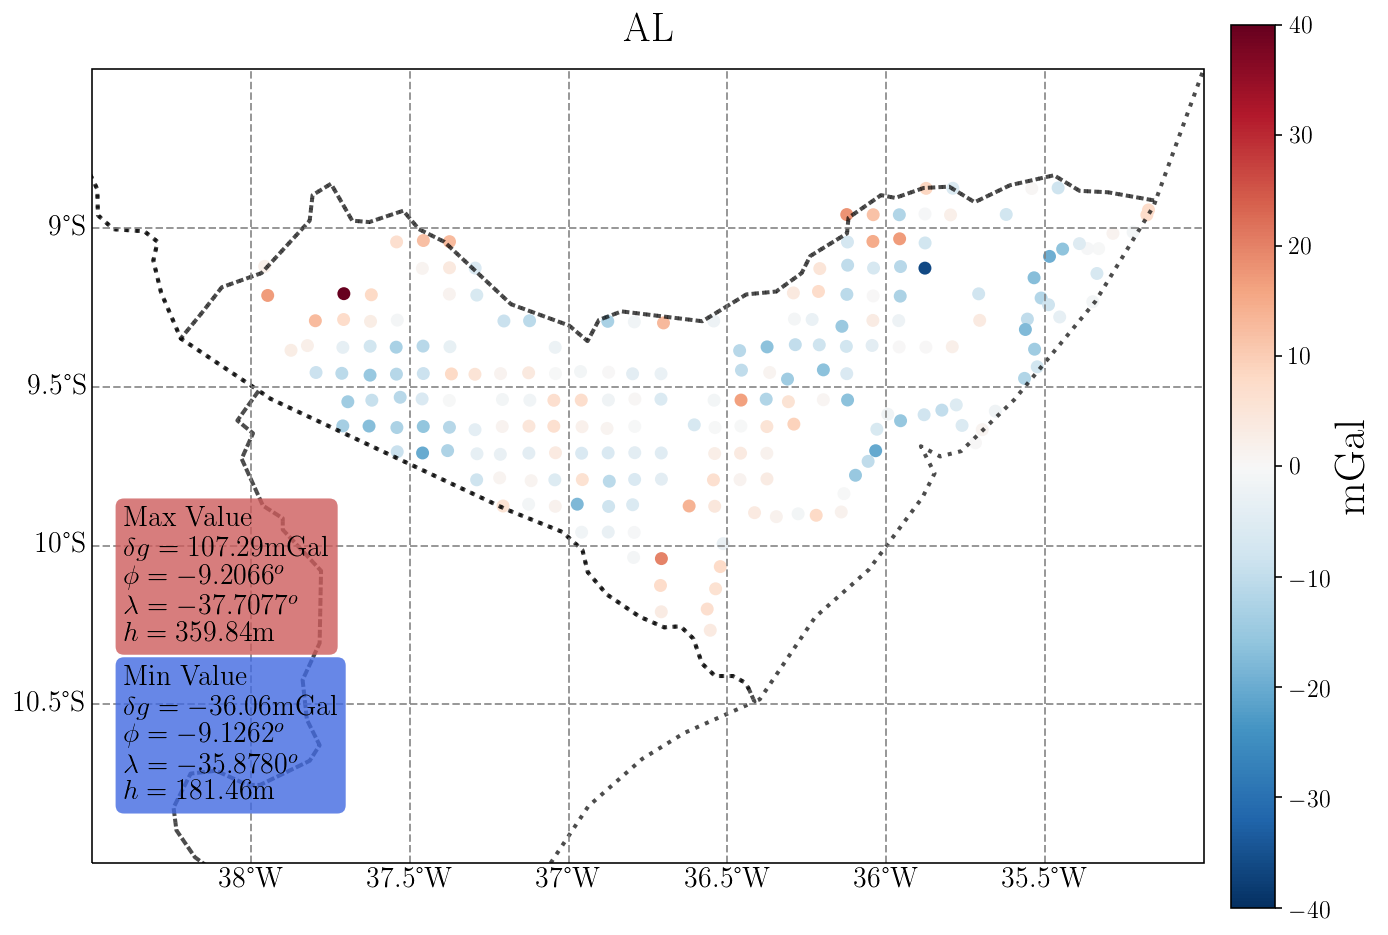

In [29]:
point_map(df.LONG, df.LAT, df.ALT, df.DIST, uf, fig_size=(12.,14.), region=[-38.5,-35,-11,-8.5], \
         sign=(-38.4,-38.4,-10.3,-10.8), shrink=0.58, lim_val=(True, 40.))

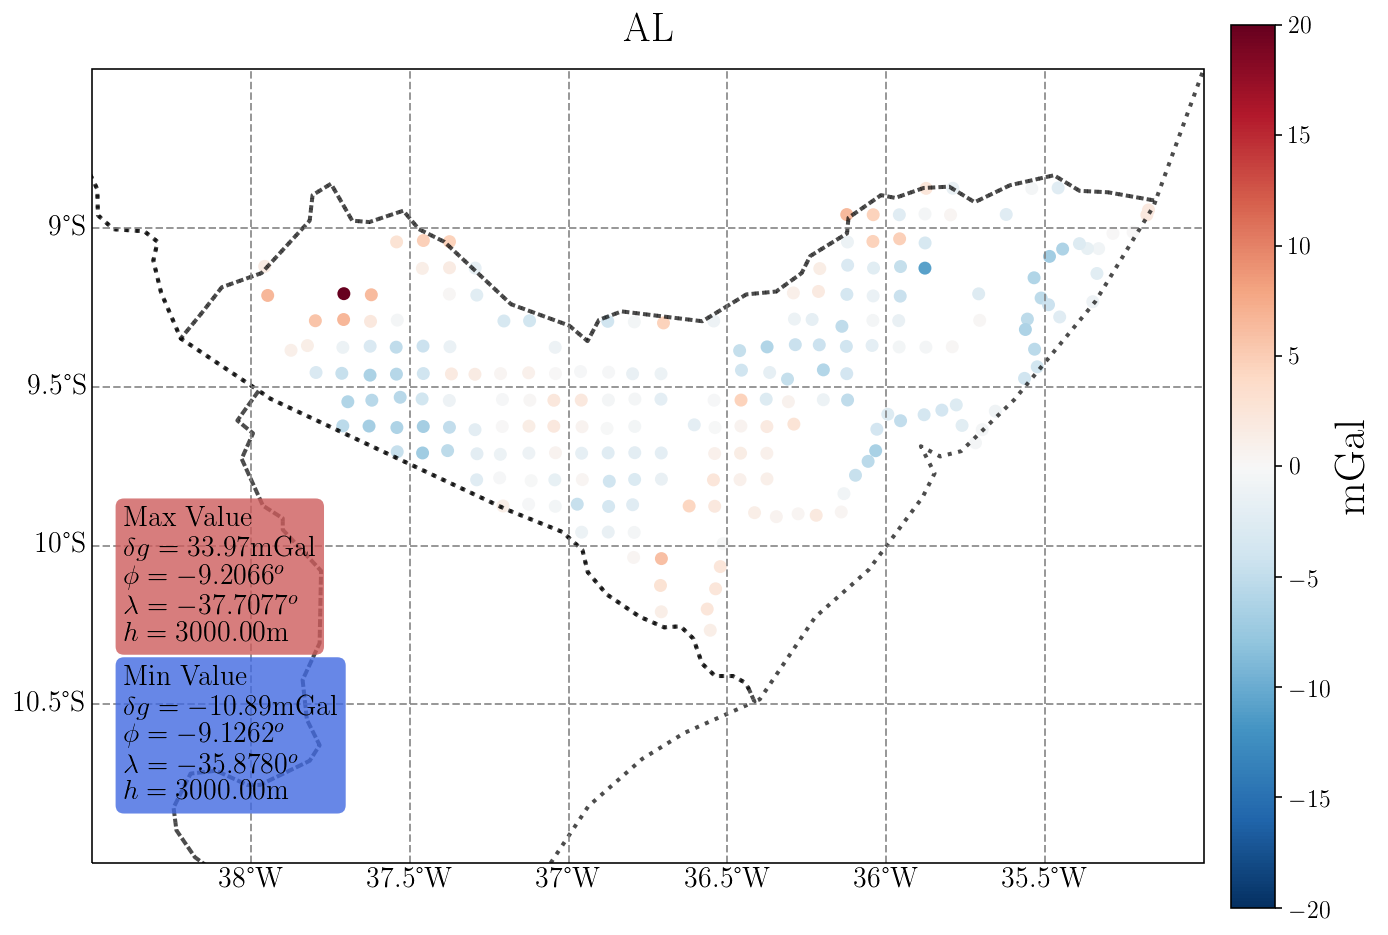

In [30]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+3000., up_cont, uf, fig_size=(12.,14.), \
          region=[-38.5,-35,-11,-8.5], sign=(-38.4,-38.4,-10.3,-10.8), shrink=0.58, lim_val=(True, 20.))

In [31]:
# Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,6000.,-3000.,p_L2)

The transformation is an upward continuation


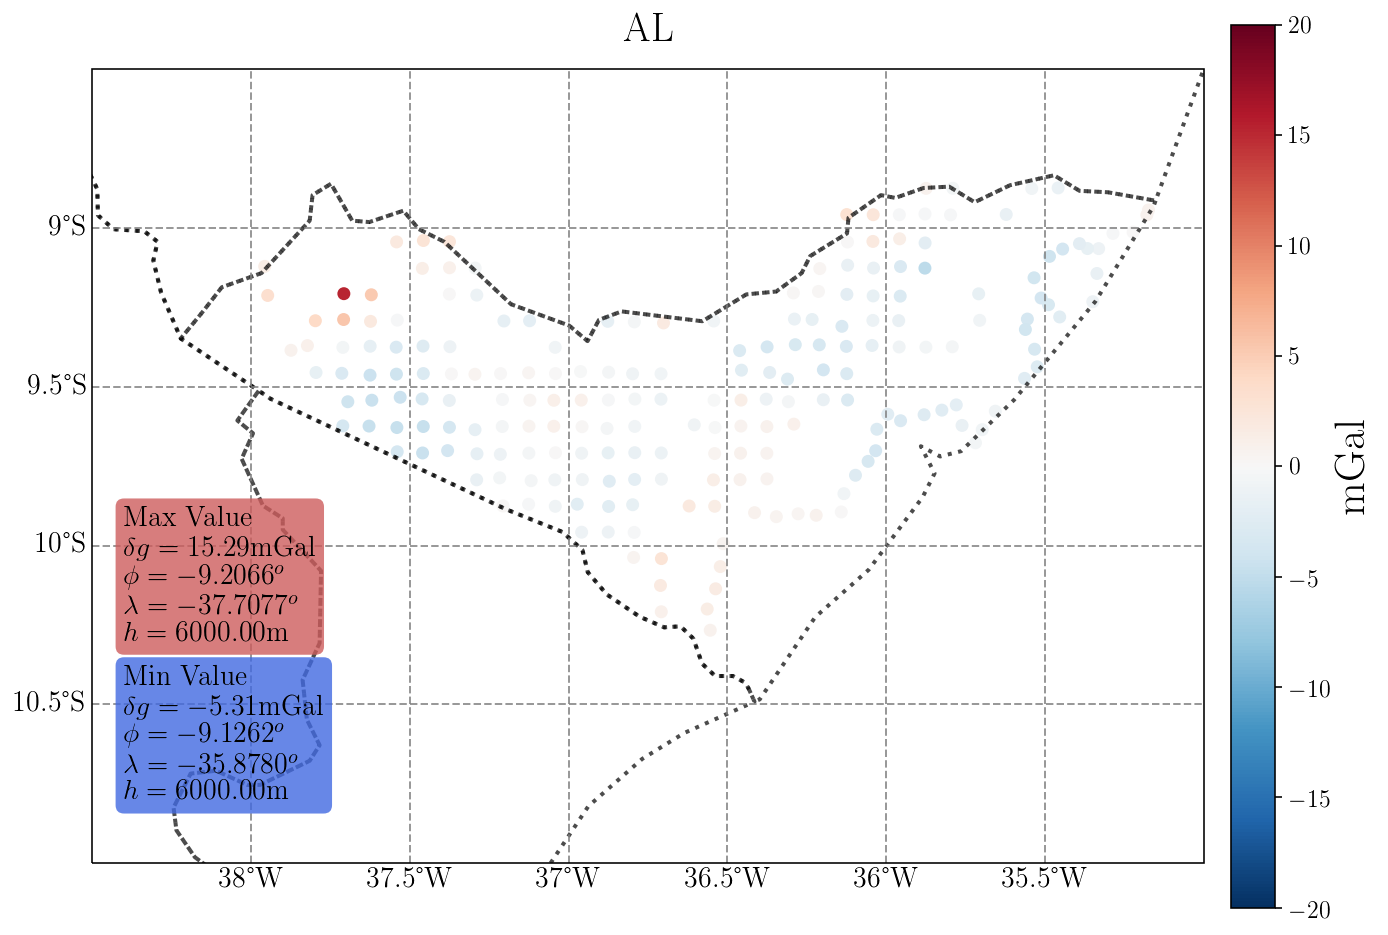

In [32]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+6000., up_cont, uf, fig_size=(12.,14.), \
          region=[-38.5,-35,-11,-8.5], sign=(-38.4,-38.4,-10.3,-10.8), shrink=0.58, lim_val=(True, 20.))

In [33]:
# Layer = EqLayer(df.LONG, df.LAT, np.zeros_like(df.LONG)-hcl)
up_cont = Layer.continuation(df.LONG,df.LAT,9000.,-3000.,p_L2)

The transformation is an upward continuation


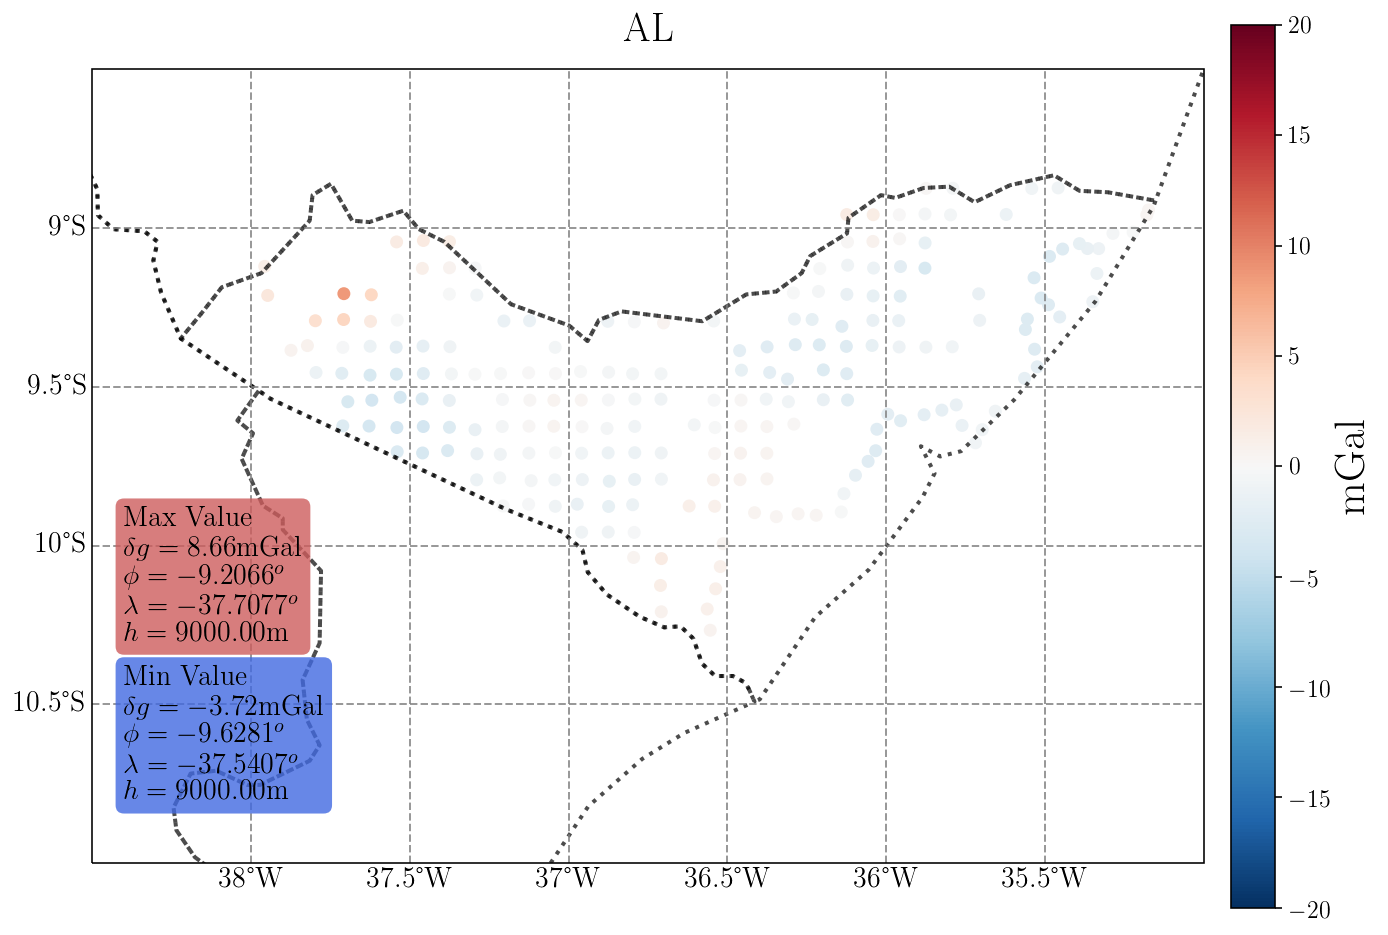

In [34]:
point_map(df.LONG, df.LAT, np.zeros_like(df.LONG)+9000., up_cont, uf, fig_size=(12.,14.), \
          region=[-38.5,-35,-11,-8.5], sign=(-38.4,-38.4,-10.3,-10.8), shrink=0.58, lim_val=(True, 20.))